### You can click here in case you want to run the code on Collabs env (It's in my Drive and I've already give you access)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1T5IeKNczRCZ5NzPfXbnn3-lHvEsRfbxe#scrollTo=qbgNaDYpIfQl"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>


# **Introduction to Meridian Demo**

Welcome to the Meridian end-to-end demo. This simplified demo showcases the fundamental functionalities and basic usage of the library, including working examples of the major modeling steps:


<ol start="0">
  <li><a href="#install">Install</a></li>
  <li><a href="#load-data">Load the data</a></li>
  <li><a href="#configure-model">Configure the model</a></li>
  <li><a href="#model-diagnostics">Run model diagnostics</a></li>
  <li><a href="#generate-summary">Generate model results & two-page output</a></li>
  <li><a href="#generate-optimize">Run budget optimization & two-page output</a></li>
  <li><a href="#save-model">Save the model object</a></li>
</ol>


Note that this notebook skips all of the exploratory data analysis and preprocessing steps. It assumes that you have completed these tasks before reaching this point in the demo.

This notebook utilizes sample data. As a result, the numbers and results obtained might not accurately reflect what you encounter when working with a real dataset.

<a name="install"></a>
## Step 0: Install

1\. Make sure you are using one of the available GPU Colab runtimes which is **required** to run Meridian. You can change your notebook's runtime in `Runtime > Change runtime type` in the menu. All users can use the T4 GPU runtime which is sufficient to run the demo colab, free of charge. Users who have purchased one of Colab's paid plans have access to premium GPUs (such as V100, A100 or L4 Nvidia GPU).

2\. Install the latest version of Meridian, and verify that GPU is available.

In [ ]:
# Install meridian: from PyPI @ latest release
!pip install --upgrade google-meridian[colab]

# Install meridian: from PyPI @ specific version
#!pip install google-meridian==1.0.0

# Install meridian: from GitHub @HEAD
#!pip install --upgrade "google-meridian[colab] @ git+https://github.com/google/meridian.git"

3\. (Optional) If you want to use simulated data, you may want to clone the meridian repository itself.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import IPython

from meridian import constants
from meridian.data import load
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

# check if GPU is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Your runtime has 19.3 gigabytes of available RAM

Num GPUs Available:  0
Num CPUs Available:  1


<a name="load-data"></a>
## Step 1: Load the data

Load the [simulated dataset in CSV format](https://github.com/google/meridian/blob/main/meridian/data/simulated_data/csv/geo_all_channels.csv) as follows.

1\. Map the column names to their corresponding variable types. For example, the column names 'GQV' and 'Competitor_Sales' are mapped to `controls`. The required variable types are `time`, `controls`, `population`, `kpi`, `revenue_per_kpi`, `media` and `spend`. If your data includes organic media or non-media treatments, you can add them using `organic_media` and `non_media_treatments` arguments. For the definition of each variable, see
[Collect and organize your data](https://developers.google.com/meridian/docs/user-guide/collect-data).

In [2]:
coord_to_columns = load.CoordToColumns(
    time='time',
    geo='geo',
    controls=['GQV', 'Competitor_Sales'],
    population='population',
    kpi='conversions',
    revenue_per_kpi='revenue_per_conversion',
    media=[
        'Channel0_impression',
        'Channel1_impression',
        'Channel2_impression',
        'Channel3_impression',
        'Channel4_impression',
    ],
    media_spend=[
        'Channel0_spend',
        'Channel1_spend',
        'Channel2_spend',
        'Channel3_spend',
        'Channel4_spend',
    ],
    organic_media=['Organic_channel0_impression'],
    non_media_treatments=['Promo'],
)

2\. Map the media variables and the media spends to the designated channel names intended for display in the two-page HTML output. In the following example,  'Channel0_impression' and 'Channel0_spend' are connected to the same channel, 'Channel0'.

In [3]:
correct_media_to_channel = {
    'Channel0_impression': 'Channel_0',
    'Channel1_impression': 'Channel_1',
    'Channel2_impression': 'Channel_2',
    'Channel3_impression': 'Channel_3',
    'Channel4_impression': 'Channel_4',
}
correct_media_spend_to_channel = {
    'Channel0_spend': 'Channel_0',
    'Channel1_spend': 'Channel_1',
    'Channel2_spend': 'Channel_2',
    'Channel3_spend': 'Channel_3',
    'Channel4_spend': 'Channel_4',
}

3\. Load the CSV data using `CsvDataLoader`. Note that `csv_path` is the path to the data file location.

In [8]:
loader = load.CsvDataLoader(
    csv_path="/Users/fcremer29/focus/meridian_test/meridian/data/simulated_data/csv/geo_all_channels.csv", #can't use relative path idk why
    kpi_type='non_revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=correct_media_to_channel,
    media_spend_to_channel=correct_media_spend_to_channel,
)
data = loader.load()

/Users/fcremer29/focus/meridian_test/demo/env/lib/python3.10/site-packages/meridian/data/load.py:201: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if (constants.GEO) not in self.dataset.dims.keys():
/Users/fcremer29/focus/meridian_test/demo/env/lib/python3.10/site-packages/meridian/data/load.py:231: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if constants.MEDIA_TIME not in self.dataset.dims.keys():


Note that the simulated data here does not contain reach and frequency. We recommend including reach and frequency data whenever they are available. For information about the advantages of utilizing reach and frequency, see [Bayesian Hierarchical Media Mix Model Incorporating Reach and Frequency Data](https://research.google/pubs/bayesian-hierarchical-media-mix-model-incorporating-reach-and-frequency-data/#:~:text=By%20incorporating%20R%26F%20into%20MMM,based%20on%20optimal%20frequency%20recommendations.). For code snippet for loading reach and frequency data, see [Load geo-level data with reach and frequency](https://developers.google.com/meridian/docs/user-guide/load-geo-data-with-rf)

The documentation provides guidance for instances where reach and frequency data is accessible for specific channels. Additionally, for information about how to load other data types and formats, including data with reach and frequency, see [Supported data types and formats](https://developers.google.com/meridian/docs/user-guide/supported-data-types-formats).

<a name="configure-model"></a>
## Step 2: Configure the model

Meridian uses Bayesian framework and Markov Chain Monte Carlo (MCMC) algorithms to sample from the posterior distribution.

1\. Inititalize the `Meridian` class by passing the loaded data and the customized model specification. One advantage of Meridian lies in its capacity to calibrate the model directly through ROI priors, as described in [Media Mix Model Calibration With Bayesian Priors](https://research.google/pubs/media-mix-model-calibration-with-bayesian-priors/). In this particular example, the ROI priors for all media channels are identical, with each being represented as Lognormal(0.2, 0.9).

In [9]:
roi_mu = 0.2     # Mu for ROI prior for each media channel.
roi_sigma = 0.9  # Sigma for ROI prior for each media channel.
prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(roi_mu, roi_sigma, name=constants.ROI_M)
)
model_spec = spec.ModelSpec(prior=prior)

mmm = model.Meridian(input_data=data, model_spec=model_spec)

I0000 00:00:1738713599.923153 1275943 service.cc:145] XLA service 0x13d291800 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738713599.923229 1275943 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1738713599.942359 1275943 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2\. Use the `sample_prior()` and `sample_posterior()` methods to obtain samples from the prior and posterior distributions of model parameters. If you are using the T4 GPU runtime this step may take about 10 minutes for the provided data set.

In [10]:
%%time
mmm.sample_prior(500)
mmm.sample_posterior(n_chains=7, n_adapt=500, n_burnin=500, n_keep=1000)

2025-02-04 21:00:44.764227: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1738713645.549710 1275943 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
W0000 00:00:1738713646.246618 1275943 assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


CPU times: user 33min 49s, sys: 8min 43s, total: 42min 32s
Wall time: 21min 5s


/Users/fcremer29/focus/meridian_test/demo/env/lib/python3.10/site-packages/arviz/data/inference_data.py:157: UserWarning: trace group is not defined in the InferenceData scheme
  warnings.warn(
/Users/fcremer29/focus/meridian_test/demo/env/lib/python3.10/site-packages/arviz/data/inference_data.py:1655: UserWarning: trace group is not defined in the InferenceData scheme
  warnings.warn(


For more information about configuring the parameters and using a customized model specification, such as setting different ROI priors for each media channel, see [Configure the model](https://developers.google.com/meridian/docs/user-guide/configure-model).

<a name="model-diagnostics"></a>
## Step 3: Run model diagnostics

After the model is built, you must assess convergence, debug the model if needed, and then assess the model fit.

1\. Assess convergence. Run the following code to generate r-hat statistics. R-hat close to 1.0 indicate convergence. R-hat < 1.2 indicates approximate convergence and is a reasonable threshold for many problems.

In [11]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

alt.LayerChart(...)

2\. Assess the model's fit by comparing the expected sales against the actual sales.

In [12]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()

alt.LayerChart(...)

For more information and additional model diagnostics checks, see [Modeling diagnostics](https://developers.google.com/meridian/docs/user-guide/model-diagnostics).

In [13]:
mmm.inference_data

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> trace

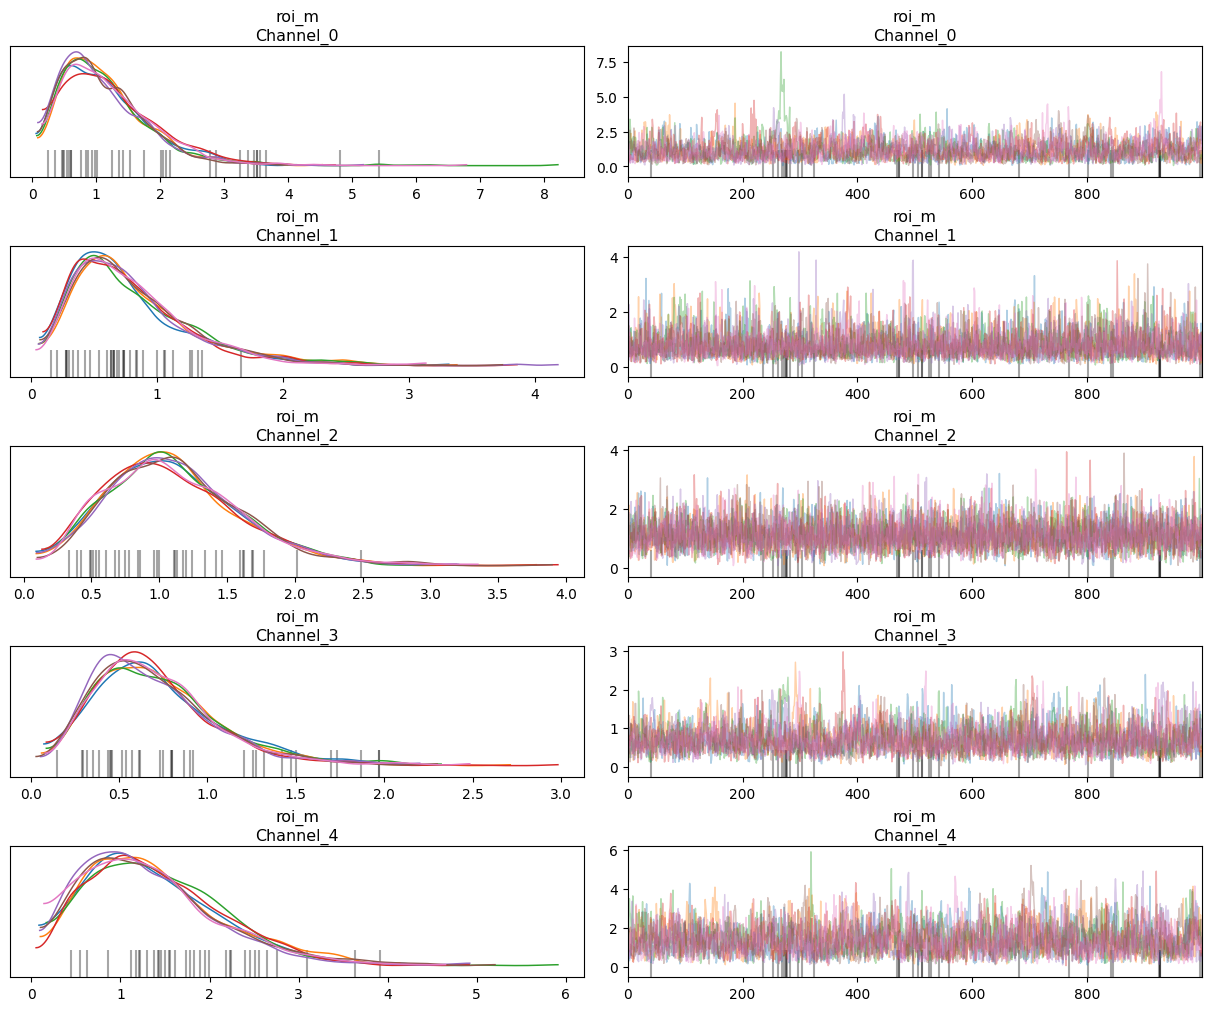

In [14]:
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )

In [15]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_prior_and_posterior_distribution()

alt.FacetChart(...)

In [16]:
model_diagnostics.plot_prior_and_posterior_distribution('beta_m')


alt.FacetChart(...)

<a name="generate-summary"></a>
## Step 4: Generate model results & two-page output

To export the two-page HTML summary output, initialize the `Summarizer` class with the model object. Then pass in the filename, filepath, start date, and end date to `output_model_results_summary` to run the summary for that time duration and save it to the specified file.

In [17]:
mmm_summarizer = summarizer.Summarizer(mmm)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [18]:
filepath = 'demo'
start_date = '2021-01-25'
end_date = '2024-01-15'
mmm_summarizer.output_model_results_summary('summary_output.html', filepath, start_date, end_date)

Here is a preview of the two-page output based on the simulated data:

In [ ]:
IPython.display.HTML(filename='summary_output.html')

For a customized two-page report, model results summary table, and individual visualizations, see [Model results report](https://developers.google.com/meridian/docs/user-guide/generate-model-results-report) and [plot media visualizations](https://developers.google.com/meridian/docs/user-guide/plot-media-visualizations).





<a name="generate-optimize"></a>
## Step 5: Run budget optimization & generate an optimization report

You can choose what scenario to run for the budget allocation. In default scenario, you find the optimal allocation across channels for a given budget to maximize the return on investment (ROI).

1\. Instantiate the `BudgetOptimizer` class and run the `optimize()` method without any customization, to run the default library's Fixed Budget Scenario to maximize ROI.

In [ ]:
%%time
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()

2\. Export the 2-page HTML optimization report, which contains optimized spend allocations and ROI.

In [ ]:
filepath = '/content/drive/MyDrive'
optimization_results.output_optimization_summary('optimization_output.html', filepath)

In [ ]:
IPython.display.HTML(filename='/content/drive/MyDrive/optimization_output.html')

For information about customized optimization scenarios, such as flexible budget scenarios, see [Budget optimization scenarios](https://developers.google.com/meridian/docs/user-guide/budget-optimization-scenarios). For more information about optimization results summary and individual visualizations, see [optimization results output](https://developers.google.com/meridian/docs/user-guide/generate-optimization-results-output) and [optimization visualizations](https://developers.google.com/meridian/docs/user-guide/plot-optimization-visualizations).

<a name="save-model"></a>
## Step 6: Save the model object

We recommend that you save the model object for future use. This helps you to  avoid repetitive model runs and saves time and computational resources. After the model object is saved, you can load it at a later stage to continue the analysis or visualizations without having to re-run the model.


Run the following codes to save the model object:

In [ ]:
file_path='/content/drive/MyDrive/saved_mmm.pkl'
model.save_mmm(mmm, file_path)

Run the following codes to load the saved model:

In [ ]:
mmm = model.load_mmm(file_path)